# Algoritmo de Agrupamento com KMeans: <br> Consumo de energia elétrica residencial individual

<br>

### Informações do conjunto de dados:
Este arquivo contém 2075259 medições reunidas em uma casa localizada em Sceaux (7km de Paris, França) entre dezembro de 2006 e novembro de 2010 (47 meses).<br>
Notas: <br>
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) representa a energia ativa consumida a cada minuto (em watt-hora) no domicílio por equipamentos elétricos não medidos nas submedições 1, 2 e 3. <br> <br>
2. O conjunto de dados contém alguns valores ausentes nas medições (quase 1,25% das linhas). Todos os carimbos de data/hora do calendário estão presentes no conjunto de dados, mas para alguns carimbos de data/hora, os valores de medição estão ausentes: um valor ausente é representado pela ausência de valor entre dois separadores de atributo ponto-e-vírgula consecutivos. Por exemplo, o conjunto de dados mostra valores ausentes em 28 de abril de 2007.

### Informações do atributo:
1. data: Data no formato dd/mm/aaaa <br>
2. hora: hora no formato hh:mm:ss <br>
3. global_active_power: potência ativa média global por minuto da família (em quilowatts) <br>
4. global_reactive_power: potência reativa global média por minuto da família (em quilowatts) <br>
5. voltage: voltagem média por minuto (em volts) <br>
6. global_intensity: intensidade de corrente média global doméstica por minuto (em amperes) <br>
7. sub_metering_1: submedição de energia nº 1 (em watt-hora de energia ativa ). Corresponde à cozinha, contendo principalmente máquina de lavar louça, forno e micro-ondas (os fogões não são elétricos, mas a gás). <br>
8. sub_metering_2: submedição de energia nº 2 (em watt-hora de energia ativa). Corresponde à lavanderia, contendo máquina de lavar, secadora, geladeira e luz. <br>
9. sub_metering_3: submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um aquecedor elétrico de água e um ar condicionado.

Repositório: <a href="Consumo de energia elétrica residencial individual">Clique aqui</a>
<hr>

## Importando Pacotes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore') 

## Carregando Dados

In [45]:
dataset = pd.read_csv('./data/01_household_power_consumption.csv', delimiter=';', low_memory=False)

In [46]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [47]:
print(f'Quantidade de Linhas: {dataset.shape[0]}\nQuantidade de Colunas: {dataset.shape[1]}')

Quantidade de Linhas: 50001
Quantidade de Colunas: 9


## Análise Exploratória

In [5]:
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [6]:
# checando se há valores missing
# dataset.isnull().values.any()
dataset.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           9
dtype: int64

In [7]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Sub_metering_3,189732.0,6.528055,8.457062,0.0,0.0,0.0,17.0,20.0


## Pré-Processamento dos Dados

In [8]:
# Remove os registros com valores NA e remove as duas primeiras colunas ( não são necessárias )
dataset = dataset.iloc[0: , 2:9].dropna()

In [9]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [10]:
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Separando as Bases

In [11]:
# formato de array
# variáveis de entrada ( os valores de "x" )
dataset_atrib = dataset.values
dataset_atrib

array([['4.216', '0.418', '234.840', ..., '0.000', '1.000', 17.0],
       ['5.360', '0.436', '233.630', ..., '0.000', '1.000', 16.0],
       ['5.374', '0.498', '233.290', ..., '0.000', '2.000', 17.0],
       ...,
       ['1.346', '0.202', '232.990', ..., '0.000', '1.000', 17.0],
       ['1.348', '0.204', '233.320', ..., '0.000', '2.000', 17.0],
       ['1.348', '0.204', '233.400', ..., '0.000', '1.000', 16.0]],
      dtype=object)

In [12]:
# coleta uma amostra de %1 dos dados para não comprometer a memória do computador ( + de 2 milhões de registros)
# os %1 estão na variável 'dataset'
dataset, amostra2 = train_test_split(dataset_atrib, train_size= .01)

In [13]:
print(f'Amostra do Dataset: {dataset.shape}\nAmostra total: {amostra2.shape}')

Amostra do Dataset: (1897, 7)
Amostra total: (187835, 7)


## Máquina Preditiva de Segmentação de Clientes

In [14]:
# Aplica redução de dimensionalidade no array das variáveis
pca = PCA(n_components=2).fit_transform(dataset)

## Curva de Elbow

In [15]:
# Determinando um range do Hyperparametro  'K' do Kmeans
k_range = range(1,12)
k_range

range(1, 12)

In [16]:
# Aplicando o modelo K-Means para cada valor de K ( numero de clusters de 1 a 12, para escolher o melhor )
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

Text(0.5, 1.0, 'Variância Explicada para cada valor de K')

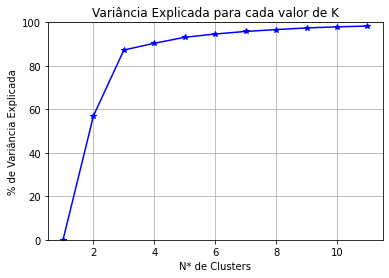

In [17]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dados para o centróide
k_euclid = [cdist(pca,cent, 'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in k_euclid]

# Soma dos quadros das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('N* de Clusters')
plt.ylabel('% de Variância Explicada')
plt.title('Variância Explicada para cada valor de K')

# Quanto maior a curva da variância , melhor
# com 8 clusters já estamos chegando no "platô", chegando no 'limite' da variância, ou seja,  não conseguimos explicar mais
# logo, o melhor valor de K parte da curva de elbow com clusters maior do que 8

In [18]:
## Escolhevendo um valor de K = 8 para avaliação da Máquina Preditiva
modelo_v1 = KMeans(n_clusters=8)
modelo_v1.fit(pca)

KMeans()

## Avaliação da Máquina Preditiva

### Avaliação da Máquina Preditiva V1

In [19]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min , x_max = pca[:, 0].min() -5 , pca[:, 0].max()-1
y_min, y_max = pca[:, 1].min() +1, pca[:, 1].max() +5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

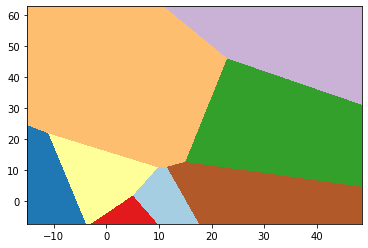

In [20]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(z, 
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect='auto',
    origin='lower'    
)

In [21]:
# Documentação
# The best value is 1 and the worst value is -1.
?silhouette_score

Signature:
silhouette_score(
    X,
    labels,
    *,
    metric='euclidean',
    sample_size=None,
    random_state=None,
    **kwds,
)
Docstring:
Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster
distance (``a``) and the mean nearest-cluster distance (``b``) for each
sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,
b)``.  To clarify, ``b`` is the distance between a sample and the nearest
cluster that the sample is not a part of.
Note that Silhouette Coefficient is only defined if number of labels
is ``2 <= n_labels <= n_samples - 1``.

This function returns the mean Silhouette Coefficient over all samples.
To obtain the values for each sample, use :func:`silhouette_samples`.

The best value is 1 and the worst value is -1. Values near 0 indicate
overlapping clusters. Negative values generally indicate that a sample has
been assigned to the wrong cluster, as a different cluster is more s

In [22]:
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric='euclidean')

0.6548443796307829

###  Avaliação da Máquina Preditiva V2

In [23]:
modelo_campeao = KMeans(n_clusters=9)
modelo_campeao.fit(pca)

KMeans(n_clusters=9)

In [24]:
labels = modelo_campeao.labels_
silhouette_score(pca, labels, metric='euclidean')

0.6619042318659425

###  Avaliação da Máquina Preditiva V3

In [25]:
modelo_v3 = KMeans(n_clusters=10)
modelo_v3.fit(pca)

KMeans(n_clusters=10)

In [26]:
labels = modelo_v3.labels_
silhouette_score(pca, labels, metric='euclidean')

0.6670818303048376

###  Avaliação da Máquina Preditiva V4

In [27]:
modelo_v4 = KMeans(n_clusters=11)
modelo_v4.fit(pca)

KMeans(n_clusters=11)

In [28]:
labels = modelo_v4.labels_
silhouette_score(pca, labels, metric='euclidean')

0.6696017005531685

###  Avaliação da Máquina Preditiva V5

In [29]:
modelo_v5 = KMeans(n_clusters=11)
modelo_v5.fit(pca)

KMeans(n_clusters=11)

In [30]:
labels = modelo_v5.labels_
silhouette_score(pca, labels, metric='euclidean')

0.6696017005531685

## Usando a Marcação dos Clusters da Máquina Preditiva Final

In [31]:
# Lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

In [32]:
# Incluindo o n* do cluster na base de clientes
cluster_map = pd.DataFrame(dataset, columns=names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = modelo_campeao.labels_

In [33]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,1.394,0.212,236.190,6.000,0.000,1.000,0.0,6
1,2.604,0.162,238.140,11.000,0.000,1.000,17.0,1
2,0.250,0.000,242.630,1.000,0.000,1.000,0.0,0
3,4.028,0.000,235.270,17.200,0.000,0.000,0.0,6
4,1.746,0.244,242.820,7.200,2.000,0.000,18.0,8
...,...,...,...,...,...,...,...,...
1892,0.286,0.220,240.140,1.400,0.000,0.000,0.0,0
1893,2.594,0.160,237.800,10.800,0.000,1.000,18.0,1
1894,0.912,0.086,240.170,3.800,0.000,0.000,0.0,0
1895,0.448,0.066,246.390,2.000,0.000,0.000,0.0,0


In [34]:
# Calcula a média de consumo de energia por cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    0.386770
1    3.190525
2    4.656279
3    3.614714
4    6.722857
5    4.557895
6    2.101920
7    3.102625
8    1.604026
Name: Global_active_power, dtype: float64

## Salvando Dados

In [35]:
cluster_map = cluster_map.loc[0:10000]
cluster_map.to_csv('./output/01_household_power_consumption_Model.csv', sep=';', index=False)

## Salvando o Modelo

In [36]:
joblib.dump(modelo_campeao, './model/01_household_power_consumption_Model.pkl')

['./model/01_household_power_consumption_Model.pkl']

## Testando o Modelo

In [37]:
loaded_movel = joblib.load('./model/01_household_power_consumption_Model.pkl')
pca = PCA(n_components=2).fit_transform(amostra2)
resultado = loaded_movel.predict(pca)

In [38]:
cluster_map = pd.DataFrame(amostra2, columns=names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power'])
cluster_map['cluster'] = resultado

In [39]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.464,0.350,242.510,2.400,0.000,1.000,0.0,0
1,2.676,0.204,241.010,11.000,0.000,0.000,18.0,1
2,0.520,0.208,240.580,2.200,0.000,0.000,0.0,0
3,0.288,0.090,240.190,1.200,0.000,0.000,0.0,0
4,0.306,0.076,243.550,1.200,0.000,0.000,0.0,0
...,...,...,...,...,...,...,...,...
187830,0.226,0.000,243.360,1.000,0.000,0.000,0.0,0
187831,0.514,0.204,250.180,2.400,0.000,0.000,0.0,0
187832,0.442,0.110,242.730,1.800,0.000,0.000,0.0,0
187833,1.478,0.108,245.730,6.000,0.000,0.000,0.0,0
